## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [10]:
import requests
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np

DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=365)

## **Data Collection**

In [4]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [5]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    if start > end:
        raise ValueError("start date must be <= end date")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
        ],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [6]:
try:
    weather_df = fetch_weather_timeseries("Dubai")
    display(weather_df.head())
    display(weather_df.tail(3))
    print(f"Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
except Exception as exc:
    print(f"Fetch failed: {exc}")


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2024-12-17,24.3,14.2,19.5,0.0
2024-12-18,23.9,18.9,21.1,0.1
2024-12-19,24.3,14.6,20.1,0.0
2024-12-20,25.4,14.2,19.5,0.0
2024-12-21,24.9,12.7,18.8,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-15,30.6,16.6,22.7,0.0
2025-12-16,26.7,20.3,23.1,0.0
2025-12-17,28.6,20.0,23.6,0.2


Fetched 366 days spanning 2024-12-17 to 2025-12-17


## **Data Exploration and Cleaning**

In [7]:
# Basic structure
print(weather_df.info())
print(weather_df.describe())

# Missing values check
print("\nMissing values per column:")
print(weather_df.isna().sum())

# Quick correlation snapshot
corr = weather_df.corr()
print("\nCorrelation matrix:")
display(corr)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-12-17 to 2025-12-17
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp_max_c   366 non-null    float64
 1   temp_min_c   366 non-null    float64
 2   temp_mean_c  366 non-null    float64
 3   precip_mm    366 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB
None
       temp_max_c  temp_min_c  temp_mean_c   precip_mm
count   366.00000  366.000000   366.000000  366.000000
mean     35.09153   22.745082    28.330874    0.025137
std       7.23623    5.945613     6.192174    0.226158
min      21.10000   10.200000    16.800000    0.000000
25%      28.90000   17.625000    22.825000    0.000000
50%      36.00000   23.550000    29.150000    0.000000
75%      41.07500   27.700000    33.600000    0.000000
max      47.90000   33.300000    39.100000    3.800000

Missing values per column:
temp_max_c     0
temp_min_c     0
temp_mean_c    0
preci

,temp_max_c,temp_min_c,temp_mean_c,precip_mm
temp_max_c,1.000000,0.901195,0.973163,-0.091025
temp_min_c,0.901195,1.000000,0.972257,-0.084872
temp_mean_c,0.973163,0.972257,1.000000,-0.092349
precip_mm,-0.091025,-0.084872,-0.092349,1.000000


<Figure size 640x480 with 0 Axes>

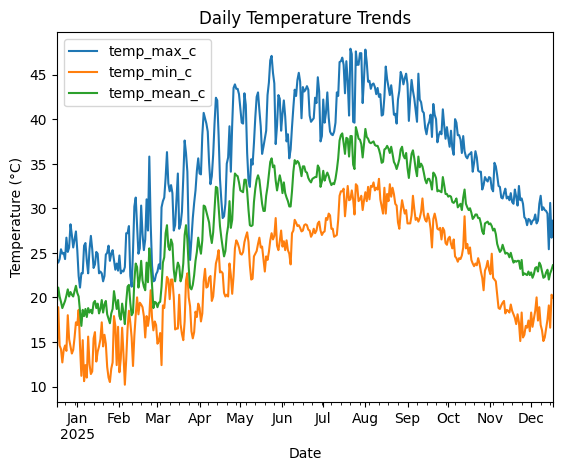

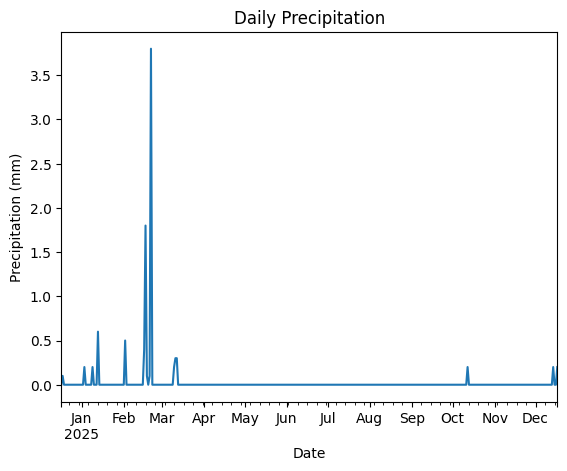

In [8]:
plt.figure()
weather_df[["temp_max_c", "temp_min_c", "temp_mean_c"]].plot()
plt.title("Daily Temperature Trends")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

plt.figure()
weather_df["precip_mm"].plot()
plt.title("Daily Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

In [11]:
df = weather_df.copy()

df["day_of_year"] = df.index.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)

<Figure size 640x480 with 0 Axes>

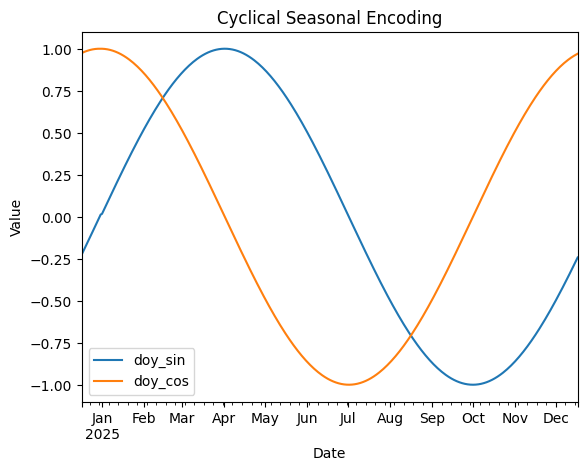

In [12]:
plt.figure()
df[["doy_sin", "doy_cos"]].plot()
plt.title("Cyclical Seasonal Encoding")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [15]:
# Check the stationarity of the data for Vector Auto Regressive

var_df = df[
    [
        "temp_max_c",
        "temp_min_c",
        "temp_mean_c",
        "precip_mm",
        "doy_sin",
        "doy_cos",
    ]
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
var_scaled = pd.DataFrame(
    scaler.fit_transform(var_df),
    index=var_df.index,
    columns=var_df.columns
)

from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    stat, pvalue, *_ = adfuller(series, autolag="AIC")
    print(f"{name}: ADF p-value = {pvalue:.4f}")

for col in var_scaled.columns:
    adf_test(var_scaled[col], col)

temp_max_c: ADF p-value = 0.6520
temp_min_c: ADF p-value = 0.6597
temp_mean_c: ADF p-value = 0.5440
precip_mm: ADF p-value = 0.0000
doy_sin: ADF p-value = 0.0000
doy_cos: ADF p-value = 0.0000


In [17]:
var_diff = var_scaled.copy()

for col in var_diff.columns:
    if adfuller(var_diff[col])[1] > 0.05:
        var_diff[col] = var_diff[col].diff()

var_diff = var_diff.dropna()

# lag order selection
from statsmodels.tsa.api import VAR

model = VAR(var_diff)
lag_results = model.select_order(maxlags=15)
print(lag_results.summary())

optimal_lag = lag_results.selected_orders["bic"]

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.05      -9.983   4.322e-05      -10.02
1      -151.2*     -150.7*  2.163e-66*     -151.0*
2       -150.3      -149.5   5.164e-66      -150.0
3       -147.7      -146.4   7.176e-65      -147.2
4       -149.1      -147.4   1.831e-65      -148.4
5       -147.5      -145.5   8.473e-65      -146.7
6       -150.2      -147.8   5.713e-66      -149.3
7       -147.5      -144.6   9.195e-65      -146.3
8       -147.4      -144.2   9.496e-65      -146.1
9       -147.6      -144.0   7.659e-65      -146.2
10      -144.3      -140.2   2.285e-63      -142.7
11      -147.2      -142.7   1.262e-64      -145.4
12      -147.7      -142.9   7.108e-65      -145.8
13      -147.6      -142.4   8.277e-65      -145.5
14      -146.8      -141.2   1.877e-64      -144.6
15      -146.4      -140.3   2.926e-64      -144.0
-------------------------------

/Users/raoabdul/Documents/Development/machine-learning/ML/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [18]:
optimal_lag = lag_results.selected_orders["bic"]

var_model = model.fit(optimal_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Dec, 2025
Time:                     21:45:12
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -79.6727
Nobs:                     364.000    HQIC:                  -79.9437
Log likelihood:           11525.3    FPE:                1.59695e-35
AIC:                     -80.1224    Det(Omega_mle):     1.53800e-35
--------------------------------------------------------------------
Results for equation temp_max_c
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.001985         0.016607            0.120           0.905
L1.temp_max_c         -0.307461         0.114580           -2.683           0.007
L1.temp_min_c         -0.390203         0.107015   

Eigenvalues of VAR(1) rep
0.3752634072069585
0.19687832864672816
0.19687832864672816
0.1203642279176463
0.9999998742598665
0.9999998742598665


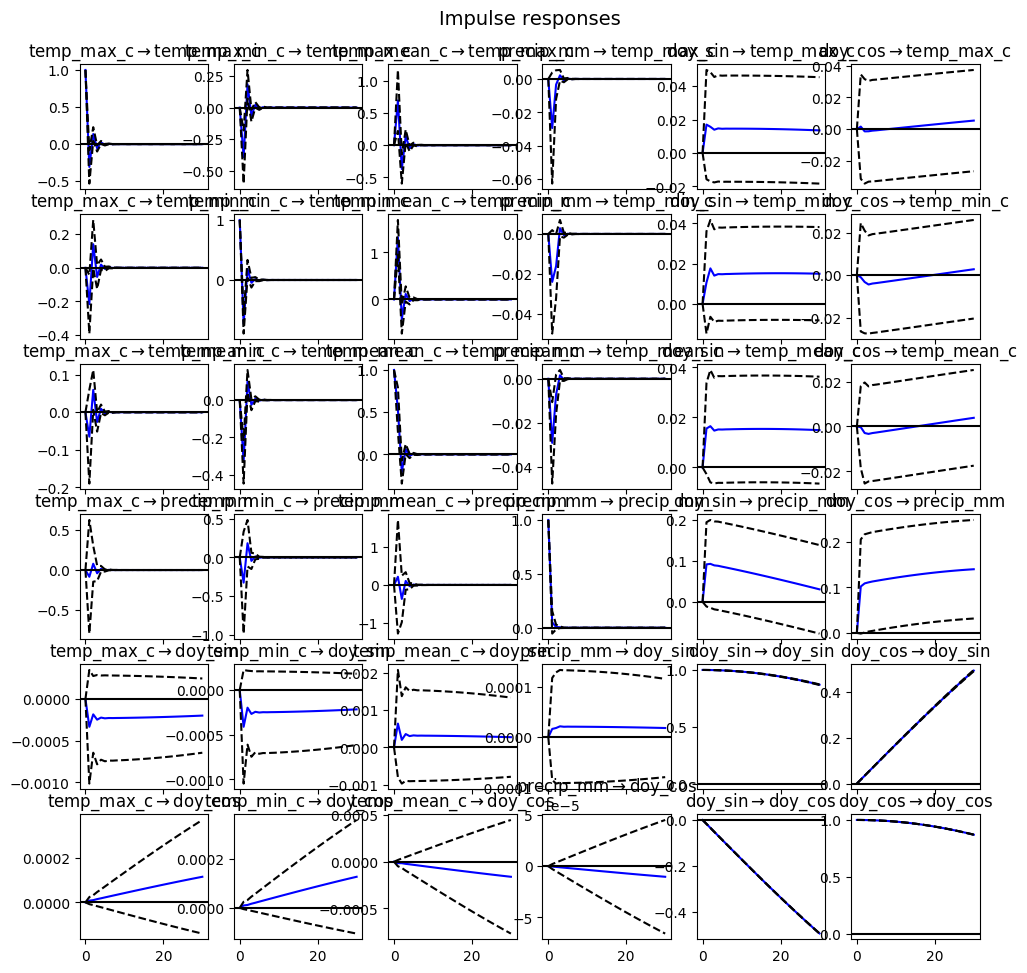

In [19]:
# stability check
var_model.is_stable(verbose=True)

irf = var_model.irf(30)
irf.plot(orth=False)

forecast_steps = 14
forecast = var_model.forecast(var_diff.values[-optimal_lag:], steps=forecast_steps)

forecast_df = pd.DataFrame(
    forecast,
    columns=var_diff.columns,
    index=pd.date_range(
        start=var_diff.index[-1] + pd.Timedelta(days=1),
        periods=forecast_steps,
        freq="D",
    ),
)

<Figure size 640x480 with 0 Axes>

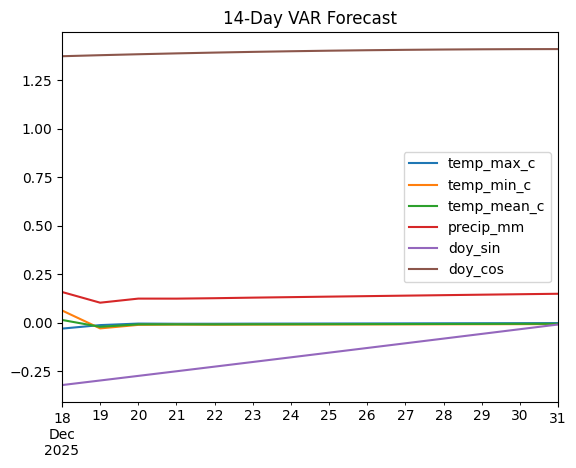

In [20]:
plt.figure()
forecast_df.plot()
plt.title("14-Day VAR Forecast")
plt.show()

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in var_model.resid.columns:
    pval = acorr_ljungbox(var_model.resid[col], lags=[10], return_df=True)["lb_pvalue"].iloc[0]
    print(f"{col}: Ljung-Box p-value = {pval:.4f}")

temp_max_c: Ljung-Box p-value = 0.0006
temp_min_c: Ljung-Box p-value = 0.0061
temp_mean_c: Ljung-Box p-value = 0.0032
precip_mm: Ljung-Box p-value = 0.0000
doy_sin: Ljung-Box p-value = 1.0000
doy_cos: Ljung-Box p-value = 1.0000


## **Weather Forecasting Model Test**

In [34]:
# Invert scaling
forecast_unscaled = pd.DataFrame(
    scaler.inverse_transform(forecast_df),
    index=forecast_df.index,
    columns=forecast_df.columns,
)

# Use the feature-augmented frame so cyclical columns are present
combined_df = pd.concat(
    [
        df[forecast_unscaled.columns],
        forecast_unscaled,
    ]
)

In [38]:
def fetch_weather_forecast(city: str, days: int = 14) -> pd.DataFrame:
    lat, lon = geocode_city(city)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
        ],
        "forecast_days": days,
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=10)
    resp.raise_for_status()
    data = resp.json()["daily"]

    df = pd.DataFrame(data)
    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)

    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )

    return df

In [36]:
actual_forecast_df = fetch_weather_forecast("Dubai", days=len(forecast_unscaled))

# Add cyclical encodings to match model outputs
actual_forecast_df["doy_sin"] = np.sin(2 * np.pi * actual_forecast_df.index.dayofyear / 365.25)
actual_forecast_df["doy_cos"] = np.cos(2 * np.pi * actual_forecast_df.index.dayofyear / 365.25)

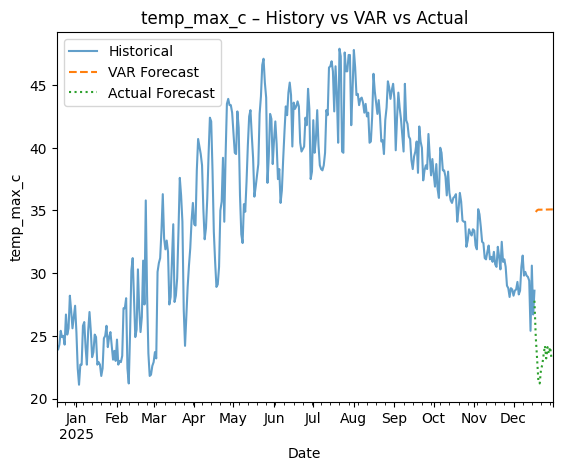

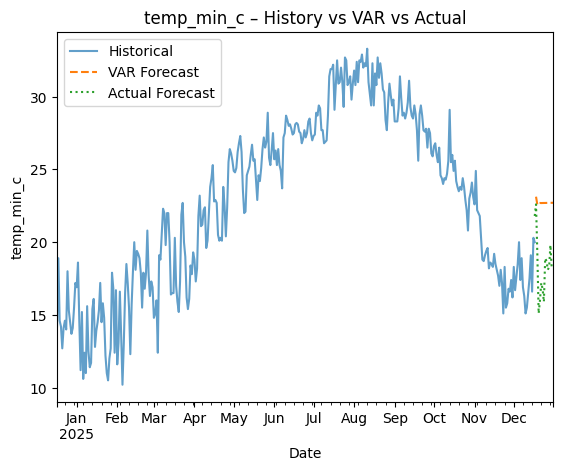

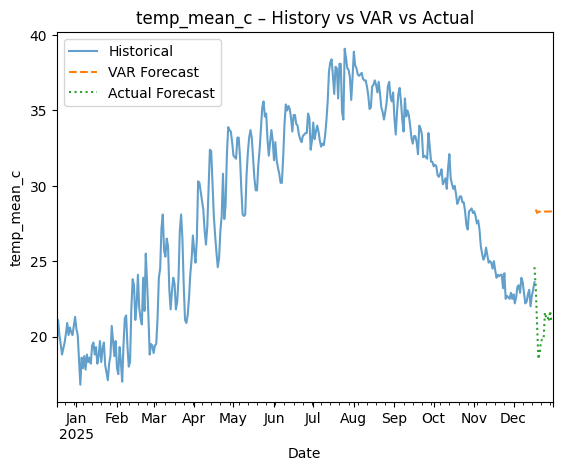

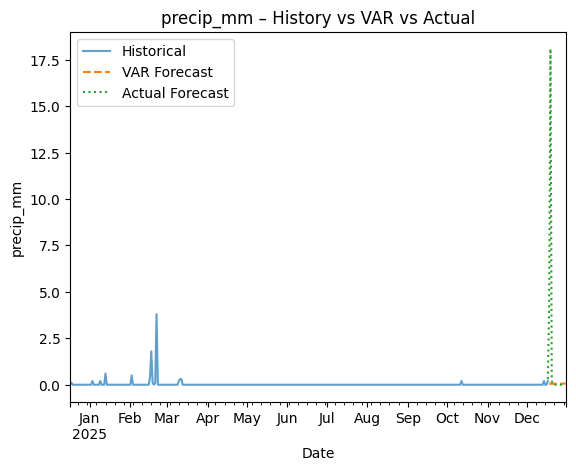

KeyError: 'doy_sin'

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt

for col in forecast_unscaled.columns:
    plt.figure()

    # Historical
    weather_df[col].plot(label="Historical", alpha=0.7)

    # VAR Forecast
    forecast_unscaled[col].plot(label="VAR Forecast", linestyle="--")

    # Actual Forecast
    actual_forecast_df[col].plot(label="Actual Forecast", linestyle=":")

    plt.title(f"{col} – History vs VAR vs Actual")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.show()
